### Lab session: representing a digital surface model with a neural network

In [7]:
pipeline = """
[
    "LHD_FXX_0808_6485_PTS_C_LAMB93_IGN69.copc.laz",
    {
        "type": "filters.sort",
        "dimension": "Z"
    }
]
"""

import pdal
r = pdal.Pipeline(pipeline)
#r.validate()
r.execute()
arrays = r.arrays


In [8]:
import numpy as np

N = arrays[0].shape[0]
X = np.zeros(N,)
Y = np.zeros(N,)
Z = np.zeros(N,)
I = np.zeros(N,)

for n in range(N):
    pt = arrays[0][n]
    X[n] = pt[0]
    Y[n] = pt[1]
    Z[n] = pt[2]
    I[n] = pt[3]

print(len(X[::100]))

215357


In [ ]:
%matplotlib ipympl
#%matplotlib widget

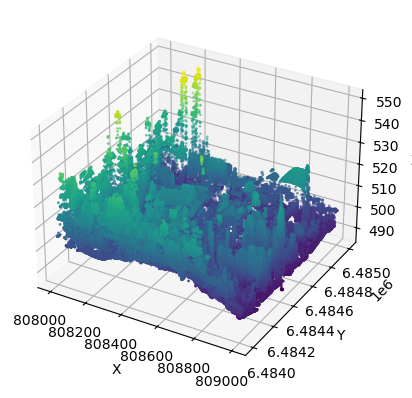

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
ax = fig.add_subplot(projection='3d')
ax.scatter(X[::100], Y[::100], Z[::100], c=Z[::100], marker='o', s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [10]:
selx = (X>808305)*(X<808538)
sely = (Y>6484516)*(Y<6484626)
sel = selx*sely

I[I>10000] = 10000 #np.max(I[I!=np.max(I)])

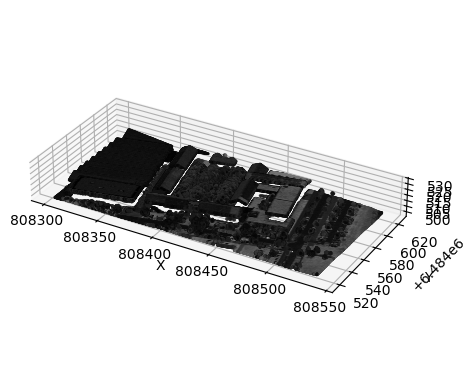

In [11]:
fig = plt.figure(2)
ax = fig.add_subplot(projection='3d')
ax.scatter(X[sel], Y[sel], Z[sel], c=I[sel], marker='o', s=1, cmap='gray')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')

plt.show()

In [12]:
Xsel = X[sel]
Ysel = Y[sel]
Zsel = Z[sel]
Isel = I[sel]
Nsel = Xsel.shape[0]

Nsmall = 50000
pts = np.rint(np.linspace(Nsel/(2*(Nsmall-1)),Nsel-Nsel/(2*(Nsmall-1)),num=Nsmall)+(np.random.rand(Nsmall)-.5)*Nsel/(Nsmall-1)).astype(np.int32)-1

Xsmall = Xsel[pts]
Ysmall = Ysel[pts]
Zsmall = Zsel[pts]
Ismall = Isel[pts]

In [13]:
Ismall[Ismall==np.max(Ismall)] = np.max(Ismall[Ismall!=np.max(Ismall)])

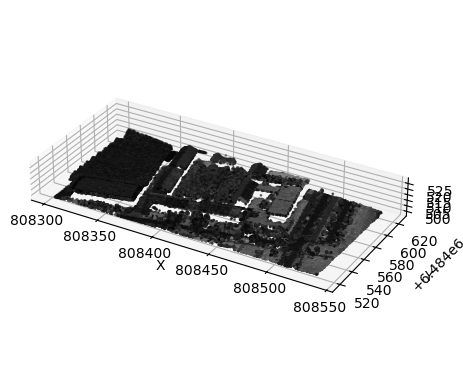

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.scatter(Xsmall, Ysmall, Zsmall, c=Ismall.astype(np.float64), marker='o', s=1)
# ax.scatter(Xsmall, Ysmall, Zsmall, c=(Ismall.astype(np.float64)-np.min(Ismall))/(np.max(Ismall)-np.min(Ismall)), marker='o', s=1,cmap='gray')
ax.scatter(Xsmall, Ysmall, Zsmall, c=(Ismall.astype(np.float64))/np.max(Ismall), marker='o', s=1,cmap='gray')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')

plt.show()

In [ ]:
import torch

inputs = np.stack([Xsmall, Ysmall], axis=1)
targets = Zsmall.reshape(-1, 1)

i_tensor = torch.tensor(inputs, dtype=torch.float32)
o_tensor = torch.tensor(targets, dtype=torch.float32)

# print(len(i_tensor))
# print(i_tensor)
# print()
# print(len(o_tensor))
# print(o_tensor)

tensor([[ 808536.5000, 6484622.0000],
        [ 808537.9375, 6484618.0000],
        [ 808536.1250, 6484623.0000],
        ...,
        [ 808509.3750, 6484516.5000],
        [ 808508.4375, 6484516.0000],
        [ 808507.6875, 6484517.5000]])


In [ ]:
from torch import nn

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu" 

class NeuralNetwork(nn.Module) :
    def __init__(self, input_dim, output_dim, width, depth = 3) :
        super().__init__(input_dim, output_dim, width, depth)

        layers = []

        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())

        for _ in range(depth - 1) :
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(width, output_dim))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x) :
        return self.linear_relu_stack(nn.Flatten(x))

In [93]:
# PLAYGROUND

w = torch.randn(2, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

z = torch.matmul(i_tensor, w) + b
loss_fn = nn.BCELoss()
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, o_tensor)

print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

loss.backward()
lr = 1e-3
print(w.data)
print(w.data - lr * w.grad.data)
print(torch.sub(w, lr * w.grad))

print(b.data)
print(b.data - lr * b.grad.data)
print(torch.sub(b, lr * b.grad))

Gradient function for z = <AddBackward0 object at 0x000001B3CECC6290>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x000001B3CECC5DB0>
tensor([[-0.4574],
        [-0.1970]])
tensor([[ 407911.8750],
        [3271972.7500]])
tensor([[ 407911.8750],
        [3271972.7500]], grad_fn=<SubBackward0>)
tensor([0.5808])
tensor([1.0854])
tensor([1.0854], grad_fn=<SubBackward0>)


In [ ]:
learning_rate = 1e-3
batch_size = 50
epochs = 5

loss_fn = nn.BCELoss()
optimizer = None

class CustomOptimizer():
    def __init__(self, params, lr) :
        super().__init__(params, lr)

    def sgd(self) :
        for p in self.params :
            if p.grad is not None : 
                p = torch.sub(p, self.lr * p.grad)
                # p.data -= learning_rate * p.grad.data
                p.grad.data.zero_()

    def zeroing_grad(self) :
        for p in self.params :
            if p.grad is not None : 
                p.grad.data.zero_()
            
def train(datas, model, loss_fn, optimizer) :
    size = i_tensor.size()
    model.train()
    for batch, (Xn, yn) in datas :
        pred = model(Xn)
        loss = loss_fn(pred, yn)

        # autodiff with PyTorch to compute derivative
        loss.backward()

        # SGD by hand
        optimizer = CustomOptimizer(model.params, learning_rate)

        optimizer.sgd()
        optimizer.zeroing_grad()

        if batch % 100 == 0 :
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(datas, model, loss_fn) :
    model.eval()
    # don't trace gradient here to avoid duplicates and gain precious computational ressources. 
    # No need to compute sgd here, we only want to evaluate the predictions


for e in range(epochs) :
    print(f"Epoch {e+1}\n-------------------------------")
    train()
    test()
print("\n---Done evaluting---")